In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.policy_guided_explorer import Explorer
from lib.implicit_mdp import PTO_wrapper
import pandas
import time

In [3]:
from lib.models.generic_v0.bitcoin import Bitcoin as G0Bitcoin
from lib.models.generic_v0.model import SelfishMining as G0Model
from lib.models.generic_v1.protocols.bitcoin import Protocol as G1Bitcoin
from lib.models.generic_v1.protocols.ghostdag import Protocol as G1Ghostdag
from lib.models.generic_v1.model import SingleAgent as G1Model
from lib.models.aft20barzur import BitcoinSM as AFT20BarZur
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

network = dict(alpha=0.33, gamma=0.33)

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


add_model(
    model="aft20barzur",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    protocol="bitcoin",
    implicit_mdp=AFT20BarZur(**network, maximum_fork_length=999999),
)
add_model(
    model="fc16sapirshtein",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    protocol="bitcoin",
    implicit_mdp=FC16Sapirshtein(**network, maximum_fork_length=999999),
)
for fco in [True, False]:
    for mi in [True, False]:
        add_model(
            model="generic_0",
            force_consider_own=fco,
            merge_isomorphic=mi,
            truncate_common_chain=True,
            collect_garbage=True,
            protocol="bitcoin",
            implicit_mdp=G0Model(
                G0Bitcoin(),
                **network,
                maximum_size=999999,
                force_consider_own=fco,
                merge_isomorphic=mi,
            ),
        )

for fco in [True, False]:
    for mi in [True, False]:
        for tcc in [True, False]:
            for cg in [True, False]:
                add_model(
                    model="generic_1",
                    force_consider_own=fco,
                    merge_isomorphic=mi,
                    truncate_common_chain=tcc,
                    collect_garbage=cg,
                    protocol="bitcoin",
                    implicit_mdp=G1Model(
                        G1Bitcoin,
                        **network,
                        force_consider_own=fco,
                        merge_isomorphic=mi,
                        collect_garbage=cg,
                        truncate_common_chain=tcc,
                    ),
                )
                add_model(
                    model="generic_1",
                    force_consider_own=fco,
                    merge_isomorphic=mi,
                    truncate_common_chain=tcc,
                    collect_garbage=cg,
                    protocol="ghostdag_3",
                    implicit_mdp=G1Model(
                        G1Ghostdag,
                        k=3,
                        **network,
                        force_consider_own=fco,
                        merge_isomorphic=mi,
                        collect_garbage=cg,
                        truncate_common_chain=tcc,
                    ),
                )


models = pandas.DataFrame(models)
models

,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,protocol
0,aft20barzur,True,True,True,True,bitcoin
1,fc16sapirshtein,True,True,True,True,bitcoin
2,generic_0,True,True,True,True,bitcoin
3,generic_0,True,False,True,True,bitcoin
4,generic_0,False,True,True,True,bitcoin
5,generic_0,False,False,True,True,bitcoin
6,generic_1,True,True,True,True,bitcoin
7,generic_1,True,True,True,True,ghostdag_3
8,generic_1,True,True,True,False,bitcoin
9,generic_1,True,True,True,False,ghostdag_3


In [4]:
horizon = 30  # paper: 100


def working_df_gen():
    for i, r in models.iterrows():
        m = PTO_wrapper(implicit_mdps[i], horizon=horizon, terminal_state=b"terminal")
        yield dict(
            implicit_mdp=m,
            explorer=Explorer(m, m.honest),
            aborted=False,
            last_distance=-1,
            last_size=-1,
            time_spent=0,
        )


working_df = pandas.DataFrame(working_df_gen())
models.join(working_df)

,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,protocol,implicit_mdp,explorer,aborted,last_distance,last_size,time_spent
0,aft20barzur,True,True,True,True,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f89...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1,0
1,fc16sapirshtein,True,True,True,True,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f89...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1,0
2,generic_0,True,True,True,True,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f89...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1,0
3,generic_0,True,False,True,True,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f89...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1,0
4,generic_0,False,True,True,True,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f89...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1,0
5,generic_0,False,False,True,True,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f89...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1,0
6,generic_1,True,True,True,True,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f89...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1,0
7,generic_1,True,True,True,True,ghostdag_3,<lib.implicit_mdp.PTO_wrapper object at 0x7f89...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1,0
8,generic_1,True,True,True,False,bitcoin,<lib.implicit_mdp.PTO_wrapper object at 0x7f89...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1,0
9,generic_1,True,True,True,False,ghostdag_3,<lib.implicit_mdp.PTO_wrapper object at 0x7f89...,<lib.policy_guided_explorer.Explorer object at...,False,-1,-1,0


In [5]:
def step_gen(max_size):
    while True:
        candidates = working_df.query(f"last_size < {max_size} and not aborted")
        if len(candidates) < 1:
            return
        yield candidates.sort_values("last_size").index[0]


from IPython.display import display, clear_output

max_size = 20000

size_log = []

for idx in step_gen(max_size):
    start_time = time.monotonic()

    row = working_df.loc[idx]

    if row.last_distance < 0:
        # first exploration of honest policy
        pass
    else:
        # increase distance by one
        try:
            row.explorer.explore_aside_policy(max_states=max_size)
            row.explorer.explore_along_policy(max_states=max_size)
        except RuntimeError as e:
            if e.args == ("state size limit exceeded",):
                working_df.loc[idx, "aborted"] = True
                continue
            else:
                raise e

    explicit_mdp = row.explorer.mdp()

    distance = row.last_distance + 1
    size = explicit_mdp.n_states

    time_spent = time.monotonic() - start_time + working_df.loc[idx, "time_spent"]
    size_log.append(
        models.loc[idx].to_dict()
        | dict(distance=distance, size=size, time_spent=time_spent)
    )

    working_df.loc[idx, "last_distance"] = distance
    working_df.loc[idx, "last_size"] = size
    working_df.loc[idx, "time_spent"] = time_spent

    clear_output()
    print("last:")
    print(models.loc[idx])
    display(
        models.join(working_df)[
            list(models.columns)
            + ["last_distance", "last_size", "aborted", "time_spent"]
        ]
    )

size_log = pandas.DataFrame(size_log)

last:
model                    aft20barzur
force_consider_own              True
merge_isomorphic                True
truncate_common_chain           True
collect_garbage                 True
protocol                     bitcoin
Name: 0, dtype: object


,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,protocol,last_distance,last_size,aborted,time_spent
0,aft20barzur,True,True,True,True,bitcoin,125,19973,False,48.753376
1,fc16sapirshtein,True,True,True,True,bitcoin,125,19910,False,126.861788
2,generic_0,True,True,True,True,bitcoin,11,18568,True,53.208789
3,generic_0,True,False,True,True,bitcoin,5,7718,True,6.978211
4,generic_0,False,True,True,True,bitcoin,6,11863,True,15.942457
5,generic_0,False,False,True,True,bitcoin,5,12705,True,9.530489
6,generic_1,True,True,True,True,bitcoin,8,9882,True,13.739901
7,generic_1,True,True,True,True,ghostdag_3,6,13445,True,57.580693
8,generic_1,True,True,True,False,bitcoin,0,6,True,0.004572
9,generic_1,True,True,True,False,ghostdag_3,6,13445,True,52.496134


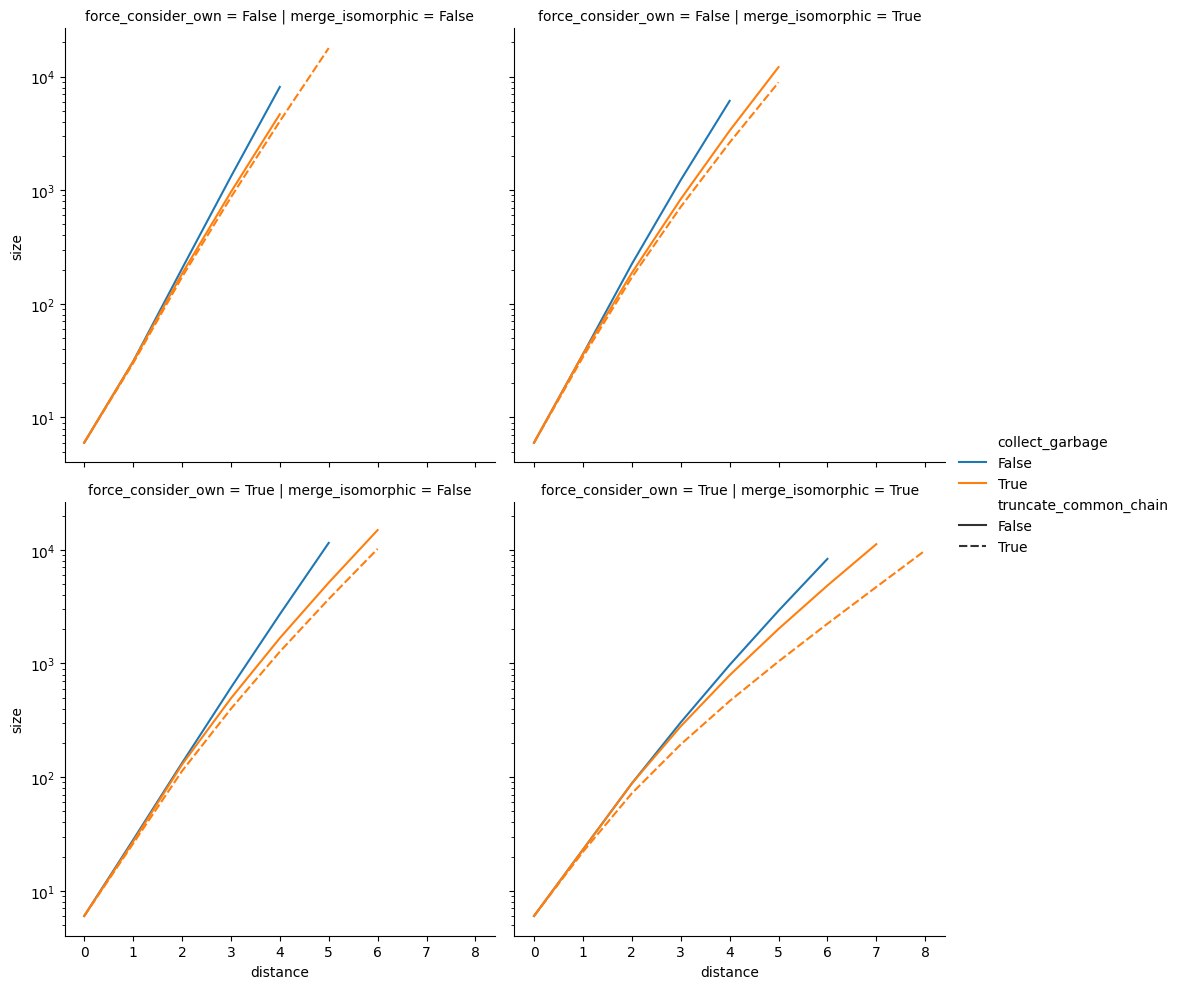

In [6]:
import seaborn

seaborn.relplot(
    data=size_log.query("protocol == 'bitcoin' and model == 'generic_1'"),
    kind="line",
    x="distance",
    y="size",
    hue="collect_garbage",
    style="truncate_common_chain",
    row="force_consider_own",
    col="merge_isomorphic",
).set(yscale="log")

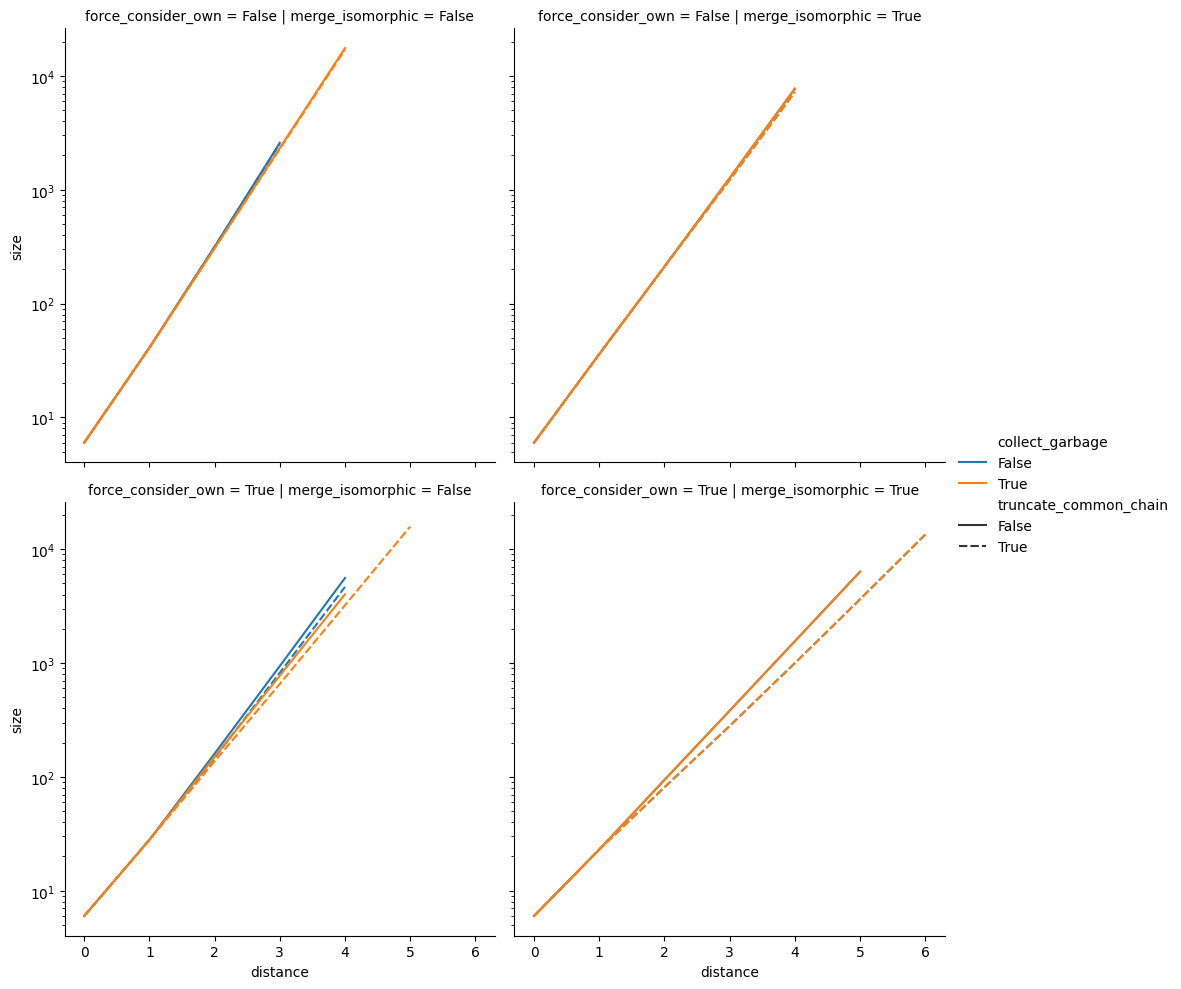

In [7]:
seaborn.relplot(
    data=size_log.query("protocol == 'ghostdag_3' and model == 'generic_1'"),
    kind="line",
    x="distance",
    y="size",
    hue="collect_garbage",
    style="truncate_common_chain",
    row="force_consider_own",
    col="merge_isomorphic",
).set(yscale="log")

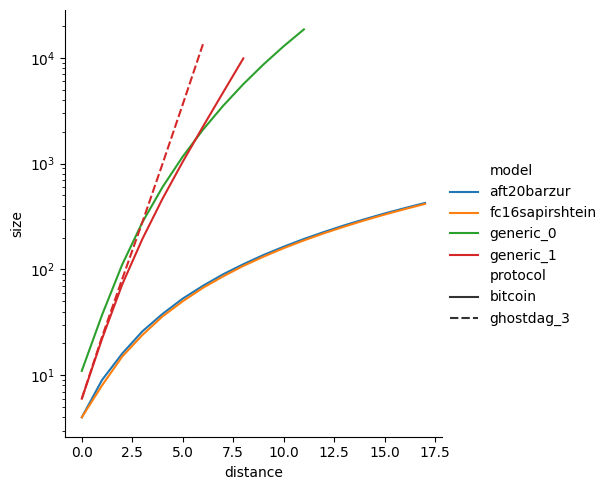

In [8]:
seaborn.relplot(
    data=size_log.query("distance <= 17").query(
        "truncate_common_chain and collect_garbage and force_consider_own and merge_isomorphic"
    ),
    kind="line",
    x="distance",
    y="size",
    hue="model",
    style="protocol",
).set(yscale="log")

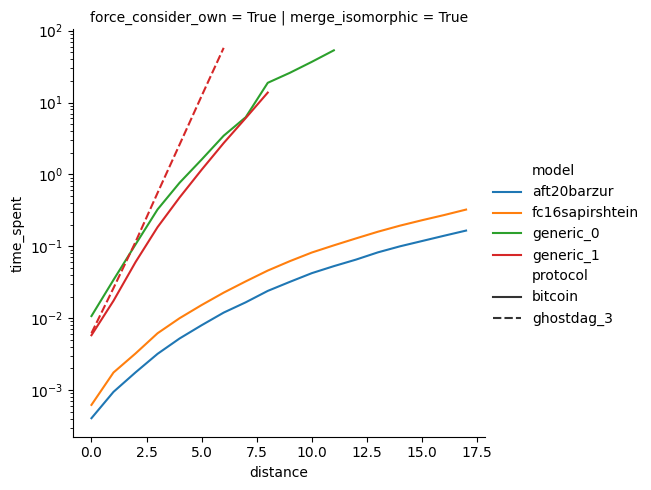

In [9]:
seaborn.relplot(
    data=size_log.query("distance <= 17").query(
        "truncate_common_chain and collect_garbage and force_consider_own and merge_isomorphic"
    ),
    kind="line",
    x="distance",
    y="time_spent",
    hue="model",
    style="protocol",
    row="force_consider_own",
    col="merge_isomorphic",
).set(yscale="log")

In [10]:
size_log.to_pickle("2-generic-v1-state-space-size.size_log.pkl.gz")